In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize
from scipy.optimize import Bounds
from multiprocessing import Pool

In [2]:
# set start and end dates
start, end = '2017-1-1', '2022-1-1'

# download index data
ticker = '^STOXX'
index = yf.download(ticker, start, end, progress=False)
index_close = index['Adj Close']

# calculate average market return and standard deviation
average_market_ret = index_close.pct_change().mean() * 21
av_m = index_close.pct_change().mean() * 253
av_std = index_close.pct_change().std() * (253**0.5)

# resample index data to weekly frequency
weekly_index = index_close.resample('1W').last().dropna()
average_weekly_index = weekly_index.pct_change().mean()

# read risk-free rate data
rf = pd.read_csv('wbond.csv')
rf_close = rf.Ultimo / 100

# define list of stocks and indexes
stocks = ['STLAM.MI', 'ENEL.MI', 'ENI.MI', 'ISP.MI', 'RACE.MI', 'STM.MI', 'G.MI', 'UCG.MI', 'CNHI.MI'] 
indexes = ['^STOXX', 'FTSEMIB.MI']


def beta_calculator(stock):
    # download data
    stock = yf.download(stock, start, end, progress = False)

    # calculate log returns and covariance
    index_log_return = np.log(index['Adj Close'] / index['Adj Close'].shift(1))
    stock_log_ret = np.log(stock['Adj Close'] / stock['Adj Close'].shift(1))
    df = pd.DataFrame({'Index': index_log_return, 'Stock': stock_log_ret}).fillna(method='bfill')
    cov_index_stock = df.cov().iloc[0,1]
    
    # calculate beta
    market_var = index_log_return.var()
    beta = cov_index_stock / market_var
    return beta

def regression(stock):
    # download data
    stock = yf.download(stock, start, end, progress=False)
    
    # calculate returns and run regression
    index_ret = index['Adj Close'].pct_change()
    stock_ret = stock['Adj Close'].pct_change()
    df = pd.DataFrame({'Index': index_ret, 'Stock': stock_ret}).dropna()
    y = df['Stock']
    X = sm.add_constant(df['Index'])
    OLS_regr = sm.OLS(y, X).fit()
    return OLS_regr.params[1]


with Pool() as pool:
    betas = pool.map(beta_calculator, stocks)
    regression_betas = pool.map(regression, stocks)

# create dataframe of betas
dftot = pd.DataFrame({'regression_betas': regression_betas}, index=stocks)
dftot['formula_betas'] = betas
dftot
print('Dispersion betas', dftot['regression_betas'].std())

Dispersion betas 0.27082068051497454


In [3]:
# calculate market weights
market_weights = [43.17, 51.07, 44.34, 36.69, 38.05, 31.59, 25.52, 24.67, 20.14, 18.82]
total_weight = np.sum(market_weights)
weights = np.array(market_weights) / total_weight

# calculate the risk-free rate based on the mean closing value
rf = rf_close.mean() * 4

exp_ret_beta = [rf + i*(average_market_ret - rf) for i in regression_betas]

mean_ret_beta, monthly_ret, mean_ri_rf = [], [], []

for i in range(len(stocks)):
    stock_close = yf.download(stocks[i], start, end, progress=False)['Adj Close'].resample('1W').last()
    li = [stock_close.pct_change()[j] - rf_close[j] for j in range(len(stock_close))]
    mean_ri_rf.append(np.nanmean(li) * 4)
    mean_ret_beta.append((regression_betas[i], stock_close.pct_change().mean() * 4))
    monthly_ret.append(stock_close.pct_change().mean() * 4)

# create dataframe and calculate alphas
dftot['mean ri-rf'] = mean_ri_rf
dftot['m_expected_returns'] = exp_ret_beta
dftot['m_mean_returns'] = monthly_ret

dftot['alphas'] = dftot['m_mean_returns'] - dftot['m_expected_returns']
dftot

,regression_betas,formula_betas,mean ri-rf,m_expected_returns,m_mean_returns,alphas
STLAM.MI,1.552083,1.555609,0.035882,0.017736,0.020550,0.002814
ENEL.MI,0.949989,0.962650,0.029881,0.004888,0.014549,0.009661
ENI.MI,1.307908,1.316362,0.019680,0.012526,0.004347,-0.008178
ISP.MI,1.295006,1.287798,0.024657,0.012250,0.009325,-0.002925
RACE.MI,0.987215,0.974808,0.040386,0.005683,0.025053,0.019371
STM.MI,1.609397,1.595468,0.045337,0.018959,0.030005,0.011046
G.MI,0.945664,0.944447,0.026694,0.004796,0.011361,0.006565
UCG.MI,1.458870,1.455224,0.023240,0.015747,0.007908,-0.007839
CNHI.MI,1.537913,1.542607,0.030187,0.017433,0.014854,-0.002579


## SML and Second Pass Regression

In [4]:
y = dftot['mean ri-rf']
X = sm.add_constant(dftot.regression_betas)
OLS_regr = sm.OLS(y, X).fit()
OLS_regr.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean ri-rf   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.109
Method:                 Least Squares   F-statistic:                    0.2151
Date:                Tue, 02 May 2023   Prob (F-statistic):              0.657
Time:                        16:24:47   Log-Likelihood:                 30.903
No. Observations:                   9   AIC:                            -57.81
Df Residuals:                       7   BIC:                            -57.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0237      0.015      1.557      0.164      -0.012       0.060
regression_betas     0.0054      0.012      0.464      0.657      -0.022       0.033
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.585
Skew:                           0.364   Prob(JB):                        0.746
Kurtosis:                       1.985   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

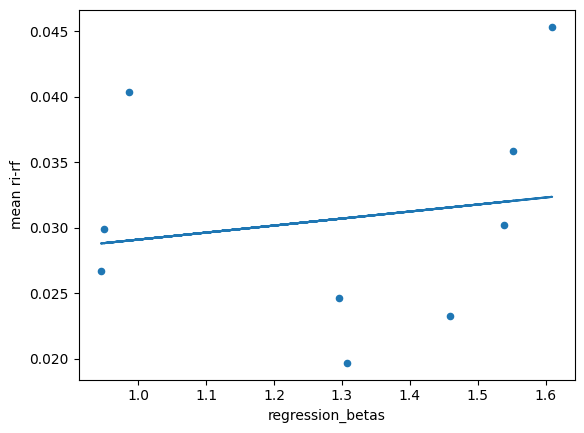

In [5]:
ax = dftot.plot(kind='scatter', x='regression_betas', y='mean ri-rf')
ax.plot(dftot.regression_betas, OLS_regr.predict());

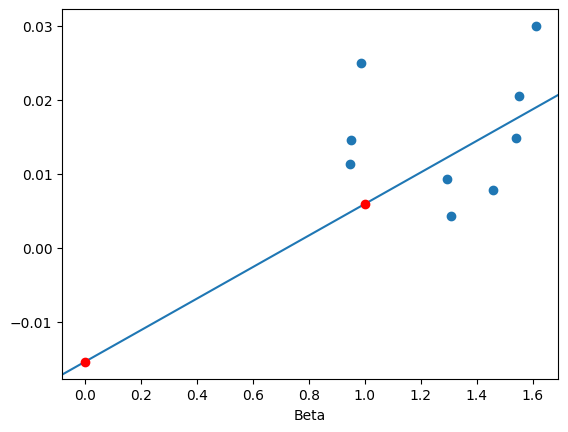

In [6]:
x1, y1 = 0, rf
x2, y2 = 1, average_market_ret
plt.axline((x1, y1), (x2, y2));
plt.plot(x1, y1, x2, y2, marker='o', color='red');
plt.scatter(*zip(*mean_ret_beta), marker='o')
plt.xlabel('Beta')
plt.show()

In [7]:
y1 = dftot['m_expected_returns']
X1 = sm.add_constant(dftot.regression_betas)
OLS_regr1 = sm.OLS(y1, X1).fit()
y2 = dftot['m_mean_returns']
X2 = sm.add_constant(dftot.regression_betas)
OLS_regr2 = sm.OLS(y2, X2).fit()
OLS_regr2.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         m_mean_returns   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.109
Method:                 Least Squares   F-statistic:                    0.2151
Date:                Tue, 02 May 2023   Prob (F-statistic):              0.657
Time:                        16:24:48   Log-Likelihood:                 30.903
No. Observations:                   9   AIC:                            -57.81
Df Residuals:                       7   BIC:                            -57.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0084      0.015      0.551      0.599      -0.028       0.044
regression_betas     0.0054      0.012      0.464      0.657      -0.022       0.033
==============================================================================
Omnibus:                        0.632   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.585
Skew:                           0.364   Prob(JB):                        0.746
Kurtosis:                       1.985   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

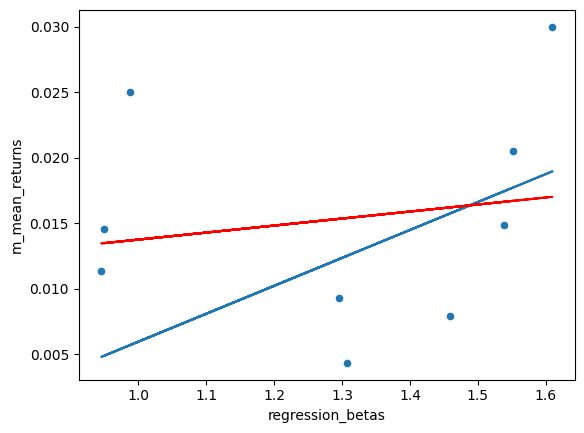

In [8]:
ax = dftot.plot(kind='scatter', x='regression_betas', y='m_mean_returns')
ax.plot(dftot.regression_betas, OLS_regr1.predict());
ax.plot(dftot.regression_betas, OLS_regr2.predict(), color='red');

## Minimum Variance Frontier and Optimal Portfolio

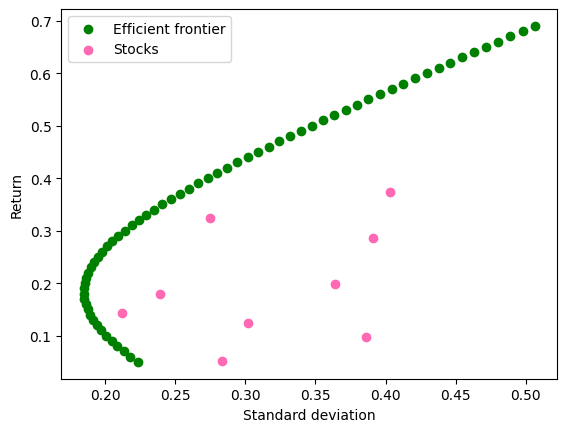

In [9]:
x = np.zeros(len(stocks))
df = yf.download(stocks, start, end, progress=False)['Adj Close'].pct_change()
df_ind_rets = df.mean()*253
df_ind_std = df.std() * (253**0.5)
cov_matrix = df.cov() * 253

def min_std(x, cov_matrix, bounds, args, ret):
    def objective_function(x, cov_matrix):
        return (x @ cov_matrix @ np.transpose(x))**0.5
    
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type':'eq', 'fun': lambda x: sum(x*df_ind_rets) - ret}
              )
    
    res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=constraints, bounds=bounds)
    return res.fun, res.x

args = (cov_matrix,)
bounds = Bounds(-2, 2)

wgt, opt_std = [], []
for i in np.arange(0.05, 0.7, 0.01):
    m = min_std(x, cov_matrix, bounds, args, ret=i)
    opt_std.append(m[0])
    wgt.append(m[1])

plt.scatter(opt_std, np.arange(0.05, 0.7, 0.01), c='green');
plt.scatter(df_ind_std, df_ind_rets, c='hotpink')
plt.xlabel('Standard deviation')
plt.ylabel('Return');
plt.legend(['Efficient frontier', 'Stocks']);

In [10]:
i = np.arange(0.05, 0.7, 0.01)
dta = pd.DataFrame({'ret': i, 'weights':wgt, 'stand':opt_std})
optimal_portfolio = dta.iloc[((dta.ret - rf)/dta.stand).idxmax()]
print('Return:', optimal_portfolio.ret)
print('Std deviation:', optimal_portfolio.stand)
print('Weights:', optimal_portfolio.weights)

Return: 0.38000000000000006
Std deviation: 0.25969234663299473
Weights: [-0.03478435  0.30960484 -0.55586453  0.55200264  0.03572231  0.57221498
  0.14555607  0.18672158 -0.21117355]
